---
  title: "EX 06"
  author: "Maksim Kulik"
  format:
    html:
      embed-resources: true
  toc: true
  jupyter: python3
---

## Step 1: Setup and Data Preprocessing

- Start by importing the necessary libraries and load the spam.csv dataset.

- Preprocess the data by encoding categorical variables, defining features and target, and splitting the data into training and testing sets. Finally, apply PCA to reduce dimensionality.

### Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Metrics for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


sns.set(font_scale = 1.25)
sns.set_style("white")


### Data overview

In [3]:
spam = pd.read_csv('data/spam.csv')
print(f'First 5 rows:\n{spam.head()}', f'Data types:\n{spam.dtypes}', f'The dataset contains {spam.shape[0]} rows and {spam.shape[1]} columns.', sep='\n\n')

First 5 rows:
   crl.tot  dollar   bang  money  n000  make yesno
0      278   0.000  0.778   0.00  0.00  0.00     y
1     1028   0.180  0.372   0.43  0.43  0.21     y
2     2259   0.184  0.276   0.06  1.16  0.06     y
3      191   0.000  0.137   0.00  0.00  0.00     y
4      191   0.000  0.135   0.00  0.00  0.00     y

Data types:
crl.tot      int64
dollar     float64
bang       float64
money      float64
n000       float64
make       float64
yesno       object
dtype: object

The dataset contains 4601 rows and 7 columns.


### Encoding categorical variables

In [4]:
categorical_columns = spam.select_dtypes(include = ['object', 'category']).columns.tolist()
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    spam[col] = label_encoders[col].fit_transform(spam[col])

### Preparation for training

In [5]:
X = spam.drop('yesno', axis = 1)
y = spam['yesno']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Step 2: Model Training and Decision Boundary Visualization

- Train a Decision Tree classifier on the PCA-transformed training data.

- Implement and use the `decisionplot` function (from the lecture) to visualize the decision boundary of your trained model.

### Training

In [9]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_pca, y_train)

DecisionTreeClassifier()

### Decisionplot

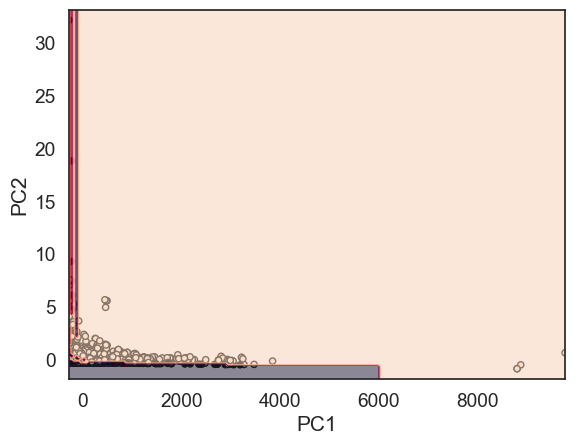

In [20]:
def decisionplot(model, X, y, resolution=200):
    # Split the data into features (X) and the class variable (y)
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict outcomes for each point on the grid
    if isinstance(model, LinearDiscriminantAnalysis):
        # For LDA, we need to use the decision_function method
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    if isinstance(model, LinearDiscriminantAnalysis):
    # Reshape LDA decision function output appropriately
        Z = Z.reshape(-1, 1)
    else:
        Z = Z.reshape(xx.shape)

    # Plot the actual data points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', s=20)

    # Overlay the decision boundary
    plt.contourf(xx, yy, Z, alpha = 0.5)
  
    # Set labels for axes
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

    plt.show()

# Visualize decision boundary
decisionplot(dtree, pd.DataFrame(X_train_pca, columns = ['PC1', 'PC2']), y_train)

## Step 3: Model Evaluation

- Evaluate your model using accuracy, precision, recall, F1 score, and AUC-ROC metrics.

In [8]:
predictions = dtree.predict(X_test_pca)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, predictions, average = 'binary')
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, predictions, average = 'binary')
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test, predictions, average = 'binary')
print(f"F1 Score: {f1:.2f}")

roc_auc_macro = roc_auc_score(y_test, predictions)
print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")

roc_auc_micro = roc_auc_score(y_test, predictions, average='micro')
print(f"Micro-average ROC-AUC: {roc_auc_micro:.2f}")

Accuracy: 0.81
Precision: 0.81
Recall: 0.73
F1 Score: 0.77
Macro-average ROC-AUC: 0.80
Micro-average ROC-AUC: 0.80


## Discussion
### The most informative metric
It seems that for a problem like predicting whether information is spam or not it is very important to avoid misclassifying useful information. It would be very annoying if a very important email was placed in the spam folder, for example. So, precision seems a good metric to look at, since the higher it is the fewer false positives we get. But we could get perfect precision just by classifying everything as negative, which is not a desirable outcome. This means it's not enough to look at just one metric. We can look at recall or accuracy for a more complete picture of our model's performance.

### Decision boundary visualization
The decision boundary plot shows us that our trained model is doing quite well: it seems to be able to correctly separate the areas with the black dots from the areas with white dots. This means it is able to successfully classify most of the time.

### Impact of PCA
The way I see it, PCA allows us to concentrate however many features we have into their essence. We can see this essence as a simple point, and we can place this point on a 2D plane. This enables visualizing the decision boundary, since we would not be able to plot a multidimensional space without losing clarity. Having fewer features saves time and resources during training and may help reduce overfitting.